In [2]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def f(x):
  return 1/(4*2*np.pi)*(np.exp(-((x)**2)/4)+np.exp(-((x-6)**2)/4)+np.exp(-((x+6)**2)/4))

def generate_samples(size=10000):
  data = []
  x = 100*(np.random.random_sample((size,))-0.5)

  for i in range(size):
    y = f(x[i])
    data.append([x[i],y])
  


  return np.array(data)


def uniform_samples(size = [10000,2]):
  s = np.random.uniform(-5,5,size = size)
  return s

In [0]:
def generator(Y,hsize = [16, 16],reuse = False):
  with tf.variable_scope("GAN/Generator",reuse = reuse):
    hidden1 = tf.layers.dense(Y,hsize[0],activation=tf.nn.leaky_relu)
    hidden2 = tf.layers.dense(hidden1,hsize[1],activation=tf.nn.leaky_relu)
    out = tf.layers.dense(hidden2,2)

  return out

In [0]:
def discriminator(X,hsize=[16,16],reuse = False):
  with tf.variable_scope("GAN/Discriminator",reuse = reuse):
    hidden1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
    hidden2 = tf.layers.dense(hidden1,hsize[1],activation=tf.nn.leaky_relu)
    hidden3 = tf.layers.dense(hidden2,2)
    out = tf.layers.dense(hidden3,1)

  return out,hidden3


In [0]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None,2])
Y = tf.placeholder(tf.float32,[None,2])

G_sample = generator(Y)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step

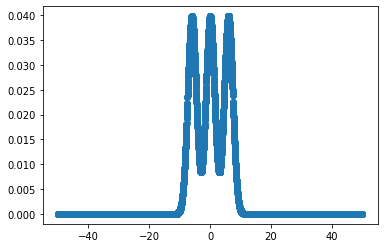

In [13]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x = generate_samples(size = 10000)
plt.scatter(x[:,0], x[:,1])
plt.show()



In [14]:
### training ####
dis_error = []
g_error = []

for i in range(200000):
  X_batch = generate_samples(size = batch_size)
  Y_batch = uniform_samples(size = [batch_size,2])
  _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Y: Y_batch})
  _, gloss = sess.run([gen_step, gen_loss], feed_dict={Y: Y_batch})
  dis_error.append(dloss)
  g_error.append(gloss)
  if i%10000 == 0:
    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))

  if i%10000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Y: Y_batch})
        xax = plt.scatter(x[:,0], x[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('/content/plots/iteration_%d.png'%i)
        plt.close()


Iterations: 0	 Discriminator loss: 5.6033	 Generator loss: 0.7267
Iterations: 10000	 Discriminator loss: 1.0809	 Generator loss: 1.1282
Iterations: 20000	 Discriminator loss: 0.9048	 Generator loss: 3.4588
Iterations: 30000	 Discriminator loss: 0.9194	 Generator loss: 3.0360
Iterations: 40000	 Discriminator loss: 0.4345	 Generator loss: 2.0613
Iterations: 50000	 Discriminator loss: 0.3720	 Generator loss: 2.6592
Iterations: 60000	 Discriminator loss: 0.3831	 Generator loss: 3.0252
Iterations: 70000	 Discriminator loss: 0.4528	 Generator loss: 2.3776
Iterations: 80000	 Discriminator loss: 0.4337	 Generator loss: 2.5358
Iterations: 90000	 Discriminator loss: 0.4572	 Generator loss: 2.1442
Iterations: 100000	 Discriminator loss: 0.4438	 Generator loss: 2.1211
Iterations: 110000	 Discriminator loss: 0.6095	 Generator loss: 2.0802
Iterations: 120000	 Discriminator loss: 0.5712	 Generator loss: 2.0952
Iterations: 130000	 Discriminator loss: 0.5286	 Generator loss: 1.9920
Iterations: 140000	 

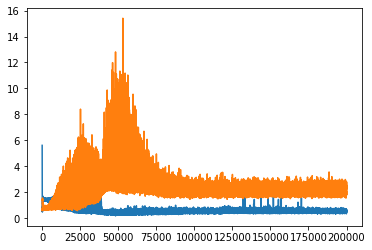

In [21]:
plt.plot(dis_error)
plt.plot(g_error)

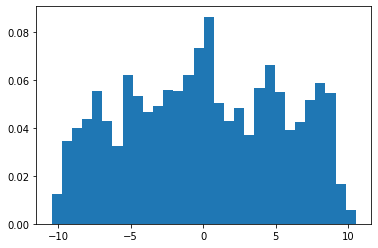

In [26]:
import scipy.stats as st
Y_batch = uniform_samples(size = [3000,2])
points = sess.run(G_sample, feed_dict={Y: Y_batch})


plt.hist(points[:,0], bins=30, density = True)
plt.show()

In [0]:
from sklearn.mixture import GaussianMixture

In [0]:
GMM = GaussianMixture(n_components=3).fit(points[:,0].reshape(-1,1))

In [41]:
print('Converged:',GMM.converged_) # Check if the model has converged
means = GMM.means_ 
covariances = GMM.covariances_
weights = GMM.weights_
print(means)
print(covariances)
print(weights)

Converged: True
[[-0.27827441]
 [-6.34254586]
 [ 6.12314662]]
[[[4.16122171]]

 [[4.36001298]]

 [[4.39271145]]]
[0.36596518 0.29979811 0.3342367 ]


In [59]:
x = GMM.sample(3000)

log_gan = GMM.score_samples(points[:,0].reshape(-1,1))
log_x = GMM.score_samples(x[0])

print(log_gan.mean() - log_x.mean())

0.004093699436420906
